In [56]:
import os
from pathlib import Path
import requests
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Any, Dict, List, Optional, Union, Annotated
from typing_extensions import Literal, TypedDict
from enum import Enum
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState, StateGraph, START, END
from googleapi_tool import TravelAssistant
from IPython.display import Image, display


In [63]:
llm = init_chat_model("gpt-4.1-mini") 

In [64]:
dotenv_path = Path(".env")
load_dotenv(dotenv_path=dotenv_path)

True

In [30]:
@tool
def nearby_place_search(
    lat: Annotated[float, "Latitude coordinate (-90 to 90)"],
    lng: Annotated[float, "Longitude coordinate (-180 to 180)"],
    topics: Annotated[str, "Search keywords (e.g., 'restaurants', 'hotels', 'attractions')"],
    radius: Annotated[Optional[int], "Search radius in meters (default: 1000)"] = 1000,
    max_places: Annotated[Optional[int], "Maximum number of places to return (default : 10)"] = 10,
    open_now: Annotated[Optional[bool], "Only return places open now (default: True)"] = True
) -> Dict[str, Any]:
    """
    Search for nearby places using Google Places API.
   
    Returns a dictionary containing information about nearby places including
    names, ratings, addresses, and other relevant details. Always keep the default
    values for radius, max_places, and open_now unless the user have specific needs.
    """
    try:
        # Get API key securely from environment
        api_key = os.getenv('GOOGLE_API')
        if not api_key:
            return {"error": "Google API key not found in environment variables"}
       
        # Create assistant and search
        assistant = TravelAssistant(api_key)
        result = assistant.find_nearby_places(
            lat=lat,
            lng=lng,
            topics=topics,
            radius=radius,
            max_places=max_places,
            open_now=open_now
        )
        return result
    except Exception as e:
        return {"error": f"Failed to search nearby places: {str(e)}"}


@tool
def get_weather(
    lat: Annotated[float, "Latitude coordinate (-90 to 90)"],
    lng: Annotated[float, "Longitude coordinate (-180 to 180)"],
) -> float:
    """
    Returns the current temperature in Celsius for the given latitude and longitude.
    """
    url = (
        f"https://api.open-meteo.com/v1/forecast"
        f"?latitude={lat}&longitude={lng}"
        f"&current=temperature_2m,wind_speed_10m"
    )
    
    response = requests.get(url)
    response.raise_for_status()  # Raise error if bad response (good practice)
    data = response.json()
    
    try:
        return data['current']['temperature_2m']
    except KeyError:
        raise ValueError("Temperature data not available in response.")


In [65]:
tools = [nearby_place_search, get_weather]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def llm_call(state: MessagesState) -> dict:
    """LLM decides whether to call a tool or not."""

    system_prompt = """You are a helpful assistant tasked with helping users find information about places and weather and act as a travel assistant.

There are specific guidelines for each tool call.
If you call for nearby_place_search, select top 3 restaurants based on reviews and ratings, and for each place in the final top 3, provide:
- Name
- Rating
- Price_Level
- A concise, summarized text combining description and review summary that highlights key aspects of the place.
- Google_Maps_Link
If you call for get_weather, provide the current temperature in Celsius.
"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=system_prompt)] + state["messages"]
            )
        ]
    }



def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

In [75]:
# result = llm_call(
#     {
#         "messages": [
#             HumanMessage(
#                 content="Recommend me some museums in Hamburg, Germany. "
#             )
#         ]
#     }
# )

# for tool_call in result['messages'][0].tool_calls:
#     toolname = tool_call["name"]
#     arguments = tool_call["args"]

# tool = tools_by_name[toolname]
# tool.invoke(arguments)

In [76]:
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

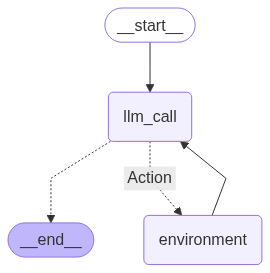

In [77]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [80]:
messages = [HumanMessage(content="Give me some asian restaurants in lat: 52.53 and lng: 13.405")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

Summarizing reviews...
Successfully saved 10 places to scraped_data.json
================================ Human Message =================================

Give me some asian restaurants in lat: 52.53 and lng: 13.405
================================== Ai Message ==================================
Tool Calls:
  nearby_place_search (call_dnJFsmzW8HiXeJluL0fHgCdD)
 Call ID: call_dnJFsmzW8HiXeJluL0fHgCdD
  Args:
    lat: 52.53
    lng: 13.405
    topics: asian restaurants
    max_places: 10
    open_now: True
================================= Tool Message =================================

{'search_parameters': {'latitude': 52.53, 'longitude': 13.405, 'topics': 'asian restaurants', 'radius': 1000, 'timestamp': '2025-06-14 17:36:17'}, 'places': [{'Name': 'Rice and Shine Berlin', 'Rating': 4.8, 'Price_Level': None, 'Place_ID': 'ChIJQdmBVwBRqEcRONRE7NCubrA', 'Google_Maps_Link': 'https://www.google.com/maps?q=place_id:ChIJQdmBVwBRqEcRONRE7NCubrA', 'Distance': 'Distance unavailable', 'Dine_In_Av